In [1]:
import os, cv2, time
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import albumentations as album

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

from torchvision import transforms

from PIL import Image

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

In [2]:
def create_paths(dataset_dir):
    rgb_files = []
    mask_files = []
    for root, dirs, files in os.walk(dataset_dir):
        for name in files:
            f = os.path.join(root, name)
            if 'labelIds' in f:
                mask_files.append(f)
            elif 'rgb_anon' in f:
                rgb_files.append(f)
            else:
                pass
    return sorted(rgb_files), sorted(mask_files)

In [3]:
class customDataset(Dataset):
    """ Custom Dataset for multiclass semantic segmentation.

    Args:
        df (pd.DataFrame): DataFrame containing paths to images and masks.
        class_list (list): List of class IDs to extract from segmentation mask.
        preprocessing (callable, optional): Data preprocessing function.
    """
    
    def __init__(self, df, class_list=None, augmentation=None, preprocessing=None):
        self.image_paths = df['rgb_file'].tolist()

        self.class_list = class_list
        self.augmentation = augmentation
        self.preprocessing = preprocessing


    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)

        # Resize images and masks
        image = cv2.resize(image, (1920, 1056), interpolation=cv2.INTER_LINEAR)

        image = np.asarray(image).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            image = self.preprocessing(image)
            image = torch.as_tensor(image)
        else:
            # Normalize image to [0, 1]
            image = torch.as_tensor(image) / 255.0
        image = image.permute(2,0,1)


        return image.float()

    def __len__(self):
        return len(self.image_paths)


In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

BACKBONE = 'resnet34'
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

In [5]:
# for ACDC-Night additional set - TEST 
dataset_test_dir = '/home/vhsillerico/Documents/datasets/acdc-test'
imgs_test_rgb, _ = create_paths(dataset_test_dir)
df_test = pd.DataFrame({'rgb_file': imgs_test_rgb})
df_test.sort_values(by='rgb_file',inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test.head(20)

,rgb_file
0,/home/vhsillerico/Documents/datasets/acdc-test...
1,/home/vhsillerico/Documents/datasets/acdc-test...
2,/home/vhsillerico/Documents/datasets/acdc-test...
3,/home/vhsillerico/Documents/datasets/acdc-test...
4,/home/vhsillerico/Documents/datasets/acdc-test...
5,/home/vhsillerico/Documents/datasets/acdc-test...
6,/home/vhsillerico/Documents/datasets/acdc-test...
7,/home/vhsillerico/Documents/datasets/acdc-test...
8,/home/vhsillerico/Documents/datasets/acdc-test...
9,/home/vhsillerico/Documents/datasets/acdc-test...


In [6]:
selected_class_list = [7, 11, 21, 26, 23]

In [7]:
# configure dataset for training
test_data = customDataset(df_test, class_list=selected_class_list)
img_test = test_data[1]
print(img_test.shape)

torch.Size([3, 1056, 1920])


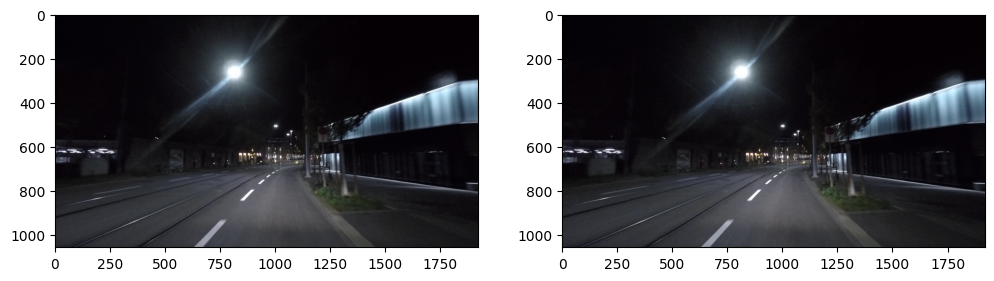

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(img_test.permute(1, 2, 0))
ax[1].imshow(img_test.permute(1, 2, 0))
plt.show()

In [9]:
test_data_loader = DataLoader(
    test_data,
    batch_size=1,
    shuffle=False
)

In [10]:
for img in test_data_loader:
    print(img.shape)
    print(img[0].min(), img[0].max())
    break

torch.Size([1, 3, 1056, 1920])
tensor(0.) tensor(1.)


In [12]:
num_classes = 6
segmodel = smp.PSPNet(encoder_name='resnext50_32x4d', encoder_weights='imagenet', classes=num_classes, activation=None).to(device)

if os.path.exists('./best_model_pspnet_multiclass_merged30e/best_model_pspnet_multiclass_merged30e.pth'):
    segmodel.load_state_dict(torch.load('./best_model_pspnet_multiclass_merged30e/best_model_pspnet_multiclass_merged30e.pth', map_location=device))
    segmodel.to(device)
    segmodel.eval()  # Set the model to evaluation mode
    print('Loaded PSPNet Multilabel model from this run.')
else:
    print("There is no saved model")

Loaded PSPNet Multilabel model from this run.


In [13]:
criterion = torch.nn.CrossEntropyLoss()

# Train model
max_score = 0
num_epochs = 1
# Training and validation loop
counter = 1
start_time = time.time()  # Track start time   
with torch.no_grad():
    # Progress bar for validation
    with tqdm(total=len(test_data_loader)) as pbar:
        for batch in test_data_loader:
            x = batch
            x = x.to(device)
            pred = segmodel(x)
            # make predictions
            pred_classes = torch.argmax(pred, dim=1)
            pbar.set_postfix({'Counter': counter})
            pbar.update(1)
            counter += 1

# Calculate and print time for each epoch
epoch_time = time.time() - start_time
print(f"Time: {epoch_time:.2f} seconds")


total_time = epoch_time * num_epochs
print(f"Estimated total inference time: {total_time/60:.2f} minutes")

  0%|          | 0/500 [00:00<?, ?it/s]

Time: 25.36 seconds
Estimated total inference time: 0.42 minutes
